# Caravan-ESP: explorar dataset
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 15-08-2023*<br>

**Introducción:**<br>

**Ideas:**<br>
* [x] ¿Y si se añaden estadísticas de caudal (discharge signatures)?
* [ ] ¿Cómo se usan atributos nominales (clases) en el LSTM? ¿Se aplica automáticamente un _one hot econder_? ¿Hay que definirlos como clases de algún modo en el archivo de configuración?
* [ ] ¿Cómo añadir un tiempo de calentamiento en el LSTM?

In [14]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import xarray as xr
from tqdm.notebook import tqdm
import yaml
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

## Configuración 

In [2]:
with open("../config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# ruta donde se ubican los datos de CAMELS-ES
path_camels = Path(cfg['rutas']['CAMELS']['repo'])

# name = 'es'
# format = 'netcdf'

## Datos
### Atributos

CAMELS-ESP contiene tres archivos CSV dentro del directorio _attributes_. Cargo los tres archivos y exploro qué datos hay en cada uno de ellos.

In [11]:
atributos = {}
for file in glob.glob(f'{path_camels}/attributes/attributes*.csv'):
    fuente = str(file).split('\\')[-1].split('_')[1]
    df = pd.read_csv(file, index_col='gauge_id')
    atributos[fuente] = df

    print(fuente.upper())
    print('-' * len(fuente))
    print('nº estaciones:\t{0}\nnº atributos:\t{1}'.format(*df.shape))
    print(df.columns.to_list(), end='\n\n')

CARAVAN
-------
nº estaciones:	269
nº atributos:	10
['p_mean', 'pet_mean', 'aridity', 'frac_snow', 'moisture_index', 'seasonality', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur']

EFAS
----
nº estaciones:	269
nº atributos:	14
['adjust_Normal_Flood', 'b_Xinanjiang', 'CalChanMan1', 'CalChanMan2', 'GwLoss', 'GwPercValue', 'LakeMultiplier', 'LowerZoneTimeConstant', 'LZThreshold', 'PowerPrefFlow', 'QSplitMult', 'ReservoirRnormqMult', 'SnowMeltCoef', 'UpperZoneTimeConstant']

HYDROATLAS
----------
nº estaciones:	269
nº atributos:	196
['sgr_dk_sav', 'glc_pc_s06', 'glc_pc_s07', 'nli_ix_sav', 'glc_pc_s04', 'glc_pc_s05', 'glc_pc_s02', 'glc_pc_s03', 'glc_pc_s01', 'pet_mm_syr', 'glc_pc_s08', 'glc_pc_s09', 'swc_pc_s09', 'ele_mt_smx', 'tbi_cl_smj', 'swc_pc_s01', 'swc_pc_s02', 'swc_pc_s03', 'swc_pc_s04', 'swc_pc_s05', 'swc_pc_s06', 'swc_pc_s07', 'swc_pc_s08', 'crp_pc_sse', 'glc_pc_s22', 'glc_pc_s20', 'glc_pc_s21', 'wet_pc_sg1', 'wet_pc_sg2', 'pac_pc_sse', 'swc_pc_s10', 'swc_pc_s1

Los atributos en las grupos _caravan_ y _other_ se explican por sí mismos. En cambio, los atributos de ***HydroAtlas*** no son claros a simple vista, pero se explican en su [catálogo](https://data.hydrosheds.org/file/technical-documentation/BasinATLAS_Catalog_v10.pdf). Los códigos de los atributos tienen el formato `atr_un_agr`, donde `agr` es una abreviatura del atributo, `un` es la unidad y `agr` el tipo de agregación, tanto espacial (cuenca, subcuenca, punto) como el estadístico utilizado (media, mínimo, máximo, mayoría...). Seguidamente enunciaré uno por uno los atributos de _HydroAtlas_ agrupados por clases. En azul se muestran aquéllos que pueden tener más interés para utilizar como atributos estáticos en el modelo LSTM.

**Cobertura del suelo**:
* Clase mayoritaria:
    * `glc_cl_smj`: predominant land cover class.
    * `pnv_cl_smj`: potential natural vegetation class.
    * `wet_cl_smj`: predominant wetland class.
* Fracción cubierta por distintos usos del suelo:
    * <font color='steelblue'>`crp_pc_sse`: fraction of cropland in the basin.
    * <font color='steelblue'>`for_pc_sse`: fraction of the subbasin cover by forest.
    * `gla_pc_sse`: fraction of subbasin cover by glaciers.
    * `glc_pc_s*`: fraction covered by 22 types of land cover.
    * `inu_pc_s*`: inundation extent. Subbasin long-term maximum, anual maximum and anual minimum.
    * <font color='steelblue'>`ire_pc_sse`: irrigated area extent.
    * <font color='steelblue'>`kar_pc_sse`: karst area extent.
    * <font color='steelblue'>`lka_pc_sse`: percent lake area.
    * `pac_pc_sse`: protected area extent.
    * `pnv_pc_s*`:  potential natural vegetation extent for each of the 15 classes.
    * `prm_pc_sse`: permafrost extent.
    * <font color='steelblue'>`pst_pc_sse`: pasture extent.
    * `snw_pc_s*`: snow cover extent. Monthly, annual maximum and annual average.
    * `urb_pc_sse`: urban extent.
    * `wet_pc_s*`: wetland extent of different classes and groups.

**Clima**:
* `ari_ix_sav`: subbasin average global aridity index.
* `cls_cl_smj`: climate strata predominant in the subbasin.
* `clz_cl_smj`: climate zone predominant in the subbasin
* `cmi_ix_s*`: subbasin climate moisture index. Datos mensuales y anual.

**Hidrología**:
* `aet`: actual evapotranspiration. Dato mensual y anual.
* `dis_m3_p*`: discharge at the subbasin pour point. Dato mínimo, máximo y medio anual.
* `gwt_cm_sav`: groundwater table depth.
* `pet_mm_s*`: potential evapotranspiration. Monthly and annual.
* `pre_mm_s*`: precipitation. Monthly and annual.
* `run_mm_syr`: annual land surface runoff.
* `swc_pc_s*`: soil water content. Montly and annual average
* `tmp_dc_s*`: air temperature. Monthly average, annual minimum, maximum and average.

**Regulación y afección antrópica**:
* <font color='steelblue'>`dor_pc_pva`: degree of regulation.
* `gdp_ud_s*`: gross domestic product. Media y total en la subcuenca.
* `hdi_ix_sav`: human development index.
* `hft_ix_s*`: human footprint in 1993 and 2009.
* <font color='steelblue'>`lkv_mc_usu`: total lake volume.
* `nli_ix_sav`: nighttime lights.
* `pop_ct_usu`: total population.
* `ppd_pk_sav`: population density.
* `rdd_mk_sav`: road density.
* <font color='steelblue'>`rev_mc_usu`: total reservoir volume.

**Tipo de suelo**:
* <font color='steelblue'>`cly_pc_sav`: subbasin average clay fraction in soil.
* `ero_kh_sav`: subbasin average soil erosion.
* <font color='steelblue'>`lit_cl_smj`: predominant lithological class.
* <font color='steelblue'>`slt_pc_sav`: silt fraction in soil.
* <font color='steelblue'>`snd_pc_sav`: sand fraction in soil.
* <font color='steelblue'>`soc_th_sav`: organic carbon content in soil.


**Topografía**:
* <font color='steelblue'>`ele_mt_s*`: elevation. Dato media, mínimo y máximo en la subcuenca.
* `ria_ha_usu`: total river area.
* `riv_tc_usu`: total river volume.
* <font color='steelblue'>`sgr_dk_sav`: stream gradient.
* <font color='steelblue'>`slp_dg_sav`: terrain slope in degrees.

**Otros**:
* `fec_cl_smj`: freshwater ecoregion.
* `fmh_cl_smj`: freshwater major habitat type
* `tbi_cl_smj`: terrestrial biome.
* `tec_cl_smj`: terrestrial ecoregions.

In [4]:
# atributos['hydroatlas'].sort_index(axis=1).columns.to_list()

C:\ProgramFiles\Anaconda3\envs\tfm\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramFiles\Anaconda3\envs\tfm\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


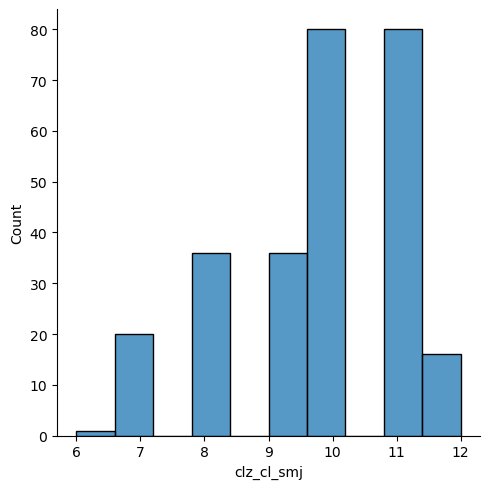

In [12]:
sns.displot(atributos['hydroatlas']['clz_cl_smj']);

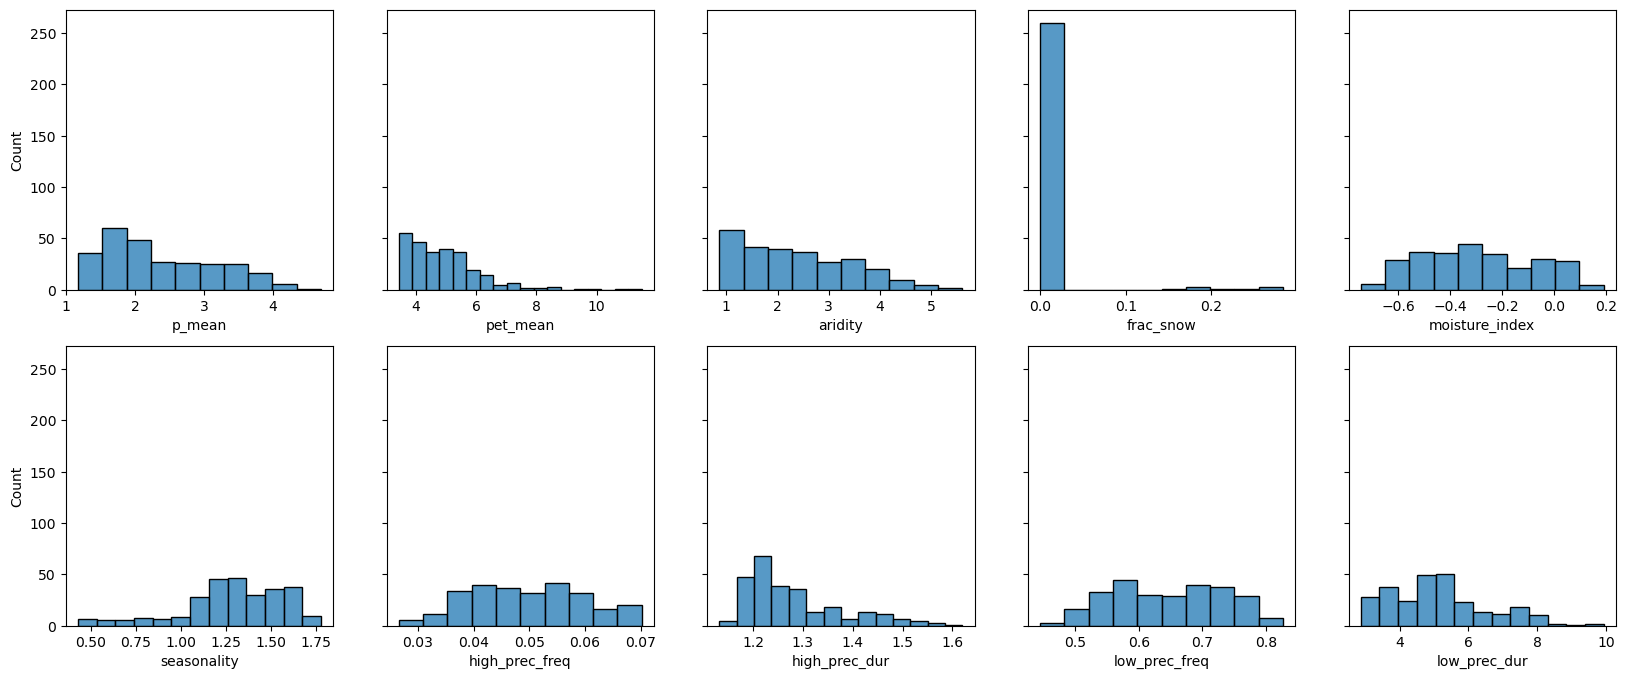

In [15]:
ncols = 5
fig, axes = plt.subplots(ncols=ncols, nrows=2, figsize=(20, 8), sharey=True)

for i, col in enumerate(atributos['caravan'].columns):
    f, c = i // ncols, i % ncols
    ax = axes[f, c]
    sns.histplot(atributos['caravan'][col], ax=ax)
    # ax.set_xlim(0, None)    

### Series temporales

In [18]:
stn = 1080
serie = xr.open_dataset(f'{path_camels}/time_series/{stn:04}.nc')

serie

<xarray.Dataset>
Dimensions:                             (date: 10958)
Coordinates:
  * date                                (date) datetime64[ns] 1990-10-01 ... ...
Data variables: (12/43)
    snow_depth_water_equivalent_mean    (date) float32 ...
    surface_net_solar_radiation_mean    (date) float32 ...
    surface_net_thermal_radiation_mean  (date) float32 ...
    surface_pressure_mean               (date) float32 ...
    temperature_2m_mean                 (date) float32 ...
    dewpoint_temperature_2m_mean        (date) float32 ...
    ...                                  ...
    potential_evaporation_sum           (date) float32 ...
    streamflow                          (date) float32 ...
    pr_emo1                             (date) float64 ...
    ta_emo1                             (date) float64 ...
    e0_emo1                             (date) float64 ...
    dis_efas5                           (date) float64 ...
Attributes:
    Units:     snow_depth_water_equivalent: ERA5-Land Snow-Water-Equivalent [...
    Timezone:  Europe/Madrid
    Sources:   All forcing and state variables are derived from ERA5-Land hou...

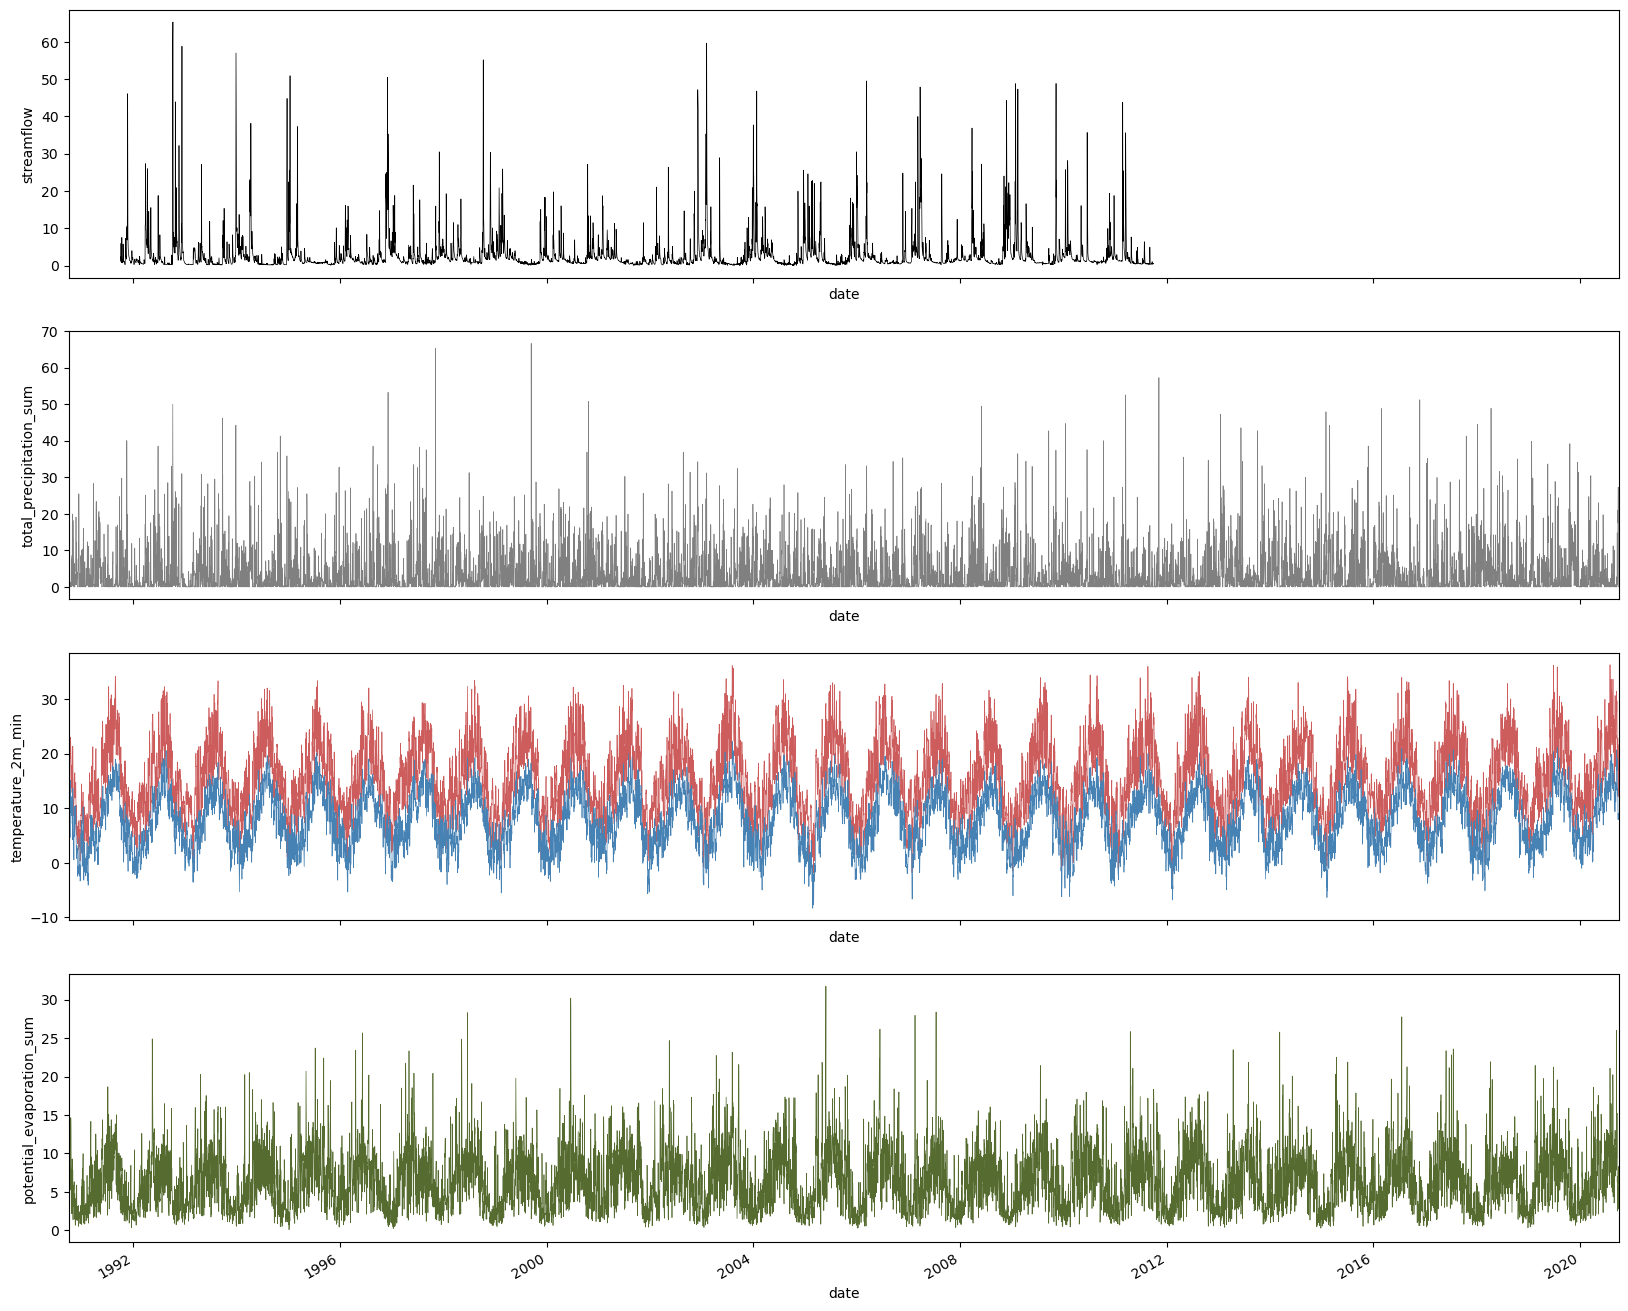

In [19]:
fig, ax = plt.subplots(nrows=4, figsize=(20, 16), sharex=True)

serie['streamflow'].plot(lw=.5, c='k', ax=ax[0])

serie['total_precipitation_sum'].plot(lw=.5, c='gray', ax=ax[1])

serie['temperature_2m_max'].plot(lw=.5, c='indianred', ax=ax[2])
serie['temperature_2m_min'].plot(lw=.5, c='steelblue', ax=ax[2])

serie['potential_evaporation_sum'].plot(lw=.5, c='darkolivegreen', ax=ax[3])

ax[0].set(xlim=(serie.date.min(), serie.date.max()));

Las series temporales incluyen 39 variables hidrometeorológicas (temperatura, presión, radiación, precipitación, ETP, humedad del suelo, caudal...). Todas las series excepto el caudal provienen de ERA5, por lo que los datos están completos. Las series de caudal, en cambio, son las series observadas del _Anuario de Aforos_, por lo que la disponibilidad de datos depende de cada estación.